# XGBoost Modeling

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

C:\Users\zasz\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\zasz\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
Using TensorFlow backend.


# 1.1 Load Data

In [3]:
train = pd.read_csv("train.csv")
val = pd.read_csv("val.csv")

# 1.2 Preprocessing

First I will have to make sure there are at least 6 rows in each class for SMOTE to work properly.

In [4]:
# see number of rows per a class
train.Type.value_counts()

2    48
1    34
7    19
3    10
5     6
6     3
Name: Type, dtype: int64

In [5]:
# copy rows for class 6
copy = train[train["Type"] == 6]
train = pd.concat([train, copy], axis=0)

Here I will scale the data

In [6]:
X_train, y_train = train.drop("Type", axis=1), train.Type
X_val, y_val = val.drop("Type", axis=1), val.Type

In [7]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

Now I will apply smote to make the classes balanced.

In [8]:
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

# 2.1 Hyper Parameter Tuning

To find the optimal parameters I will use a grid search.

In [9]:
params = {"max_depth":[2, 3, 4, None]}
gscv = GridSearchCV(XGBClassifier(), params)

gscv.fit(X_train, y_train)
gscv.best_params_

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 2}

Now I will do a more fine combed search

In [10]:
params = {"max_depth": [4,  5, 6]}
gscv = GridSearchCV(XGBClassifier(), params)

gscv.fit(X_train, y_train)
gscv.best_params_

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 4}

In [11]:
# save model
model = gscv.best_estimator_

# 3.1 Evaluation

Here I will see how well the model does on the training and validation sets.

In [12]:
# fit
model.fit(X_train, y_train)

# training predictions
train_pred = model.predict(X_train)

# validation predictions
val_pred = model.predict(X_val)

# scores
print("training performance")
print(classification_report(y_train, train_pred))

print("validation performance")
print(classification_report(y_val, val_pred))

training performance
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        48
           2       1.00      1.00      1.00        48
           3       1.00      1.00      1.00        48
           5       1.00      1.00      1.00        48
           6       1.00      1.00      1.00        48
           7       1.00      1.00      1.00        48

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288

validation performance
              precision    recall  f1-score   support

           1       0.86      0.67      0.75        18
           2       0.43      1.00      0.60         6
           3       1.00      0.50      0.67         4
           5       0.75      0.75      0.75         4
           6       1.00      0.50      0.67         2
           7       1.00      0.83      0.91         6

    accuracy                     

The model is over fit so I will try reducing the max depth parameter

In [20]:
# alter parameter 
model.set_params(max_depth = 2)

# fit
model.fit(X_train, y_train)

# validation predictions
val_pred = model.predict(X_val)

# scores
print("training performance")
print(classification_report(y_train, train_pred))

print("validation performance")
print(classification_report(y_val, val_pred))

training performance
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        48
           2       1.00      1.00      1.00        48
           3       1.00      1.00      1.00        48
           5       1.00      1.00      1.00        48
           6       1.00      1.00      1.00        48
           7       1.00      1.00      1.00        48

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288

validation performance
              precision    recall  f1-score   support

           1       0.86      0.67      0.75        18
           2       0.45      0.83      0.59         6
           3       1.00      0.50      0.67         4
           5       0.67      1.00      0.80         4
           6       1.00      0.50      0.67         2
           7       0.83      0.83      0.83         6

    accuracy                     

Next I will look at the feature importances

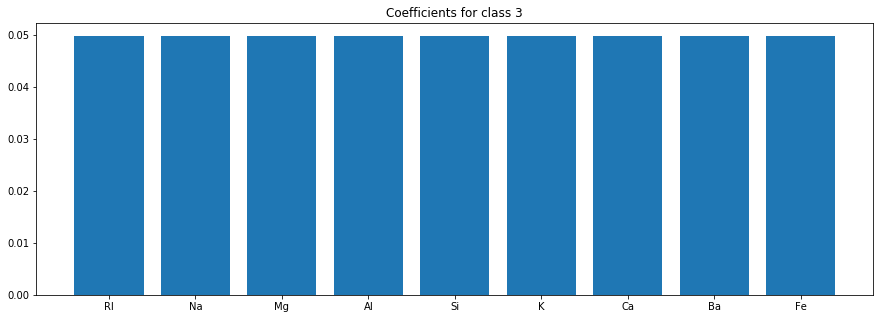

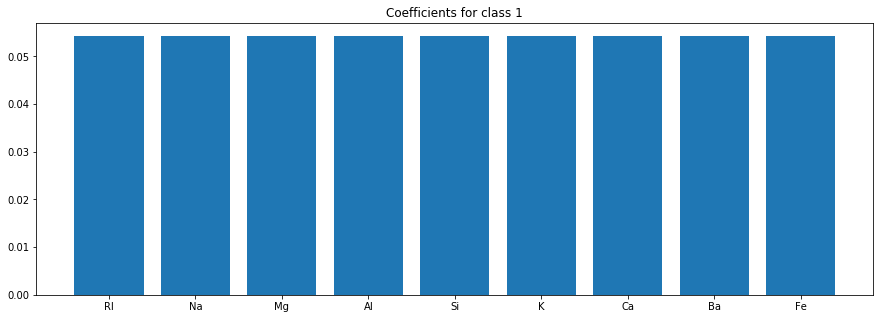

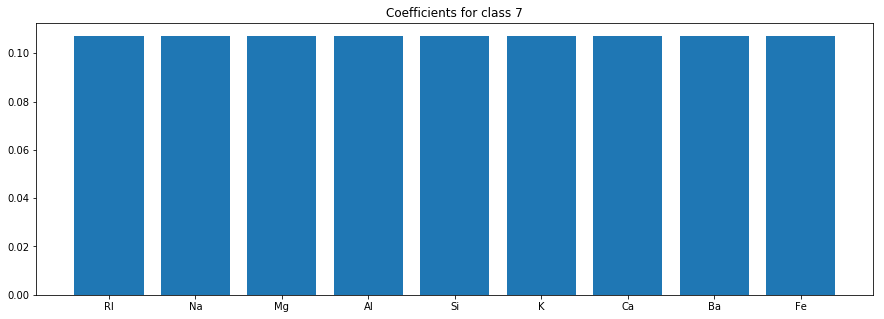

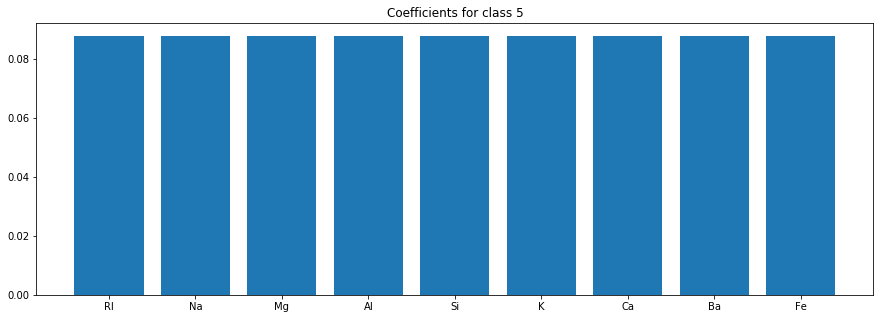

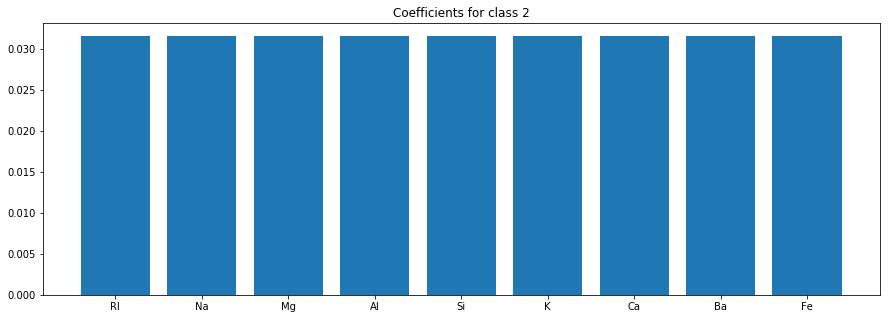

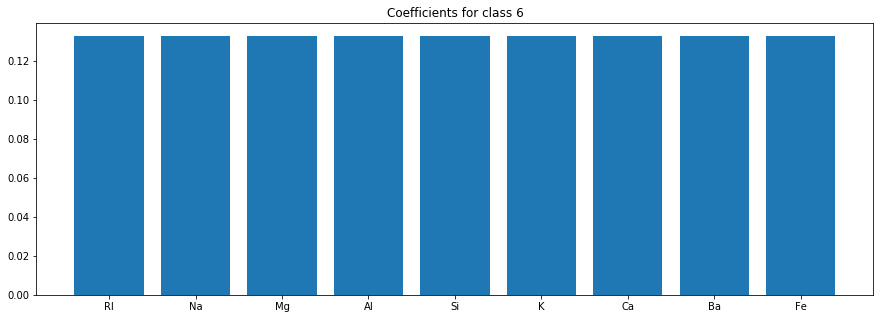

In [21]:
# loop through classes and print feature importances for each one
for n, t in enumerate(train.Type.unique()):
    plt.figure(figsize=(15, 5))
    plt.bar(train.drop("Type", axis=1).columns, model.feature_importances_[n])
    plt.title(f"Coefficients for class {t}")
    plt.show()

It seems all the features are useful.